<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as ggplot
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta

import os
import re

from functools import reduce
from collections import defaultdict

import prophet as pr


# Customer Analysis

In [2]:
os.listdir()

['.config',
 '1_orders_dataset.csv',
 'sales_vs_discount.csv',
 'online_retail.xlsx',
 'sales.csv',
 'ecommerce-data.csv',
 'groceries.csv',
 'online_retail_II.xlsx',
 'mock_sales_data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'match_result_test.csv',
 '1_order_payments_dataset.csv',
 'mall_customers.csv',
 'test.csv',
 '1_customers_dataset.csv',
 'bz_data_analyis.csv',
 'scanner_data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sales_data_with_stores.csv',
 'sample-sales-data.csv',
 'sample_data']

In [11]:
df = pd.read_csv('scanner_data.csv').drop('Unnamed: 0', axis = 1)
df.columns = [a.lower() for a in df.columns]
df['ds'] = pd.to_datetime(df['date'], infer_datetime_format = True)
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,ds
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-02-01
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-02-01
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-02-01
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01


In [44]:
cnt = df['sku_category'].value_counts().reset_index().rename(columns = {'index': 'sku_category', 'sku_category':'cnt'})
cnt['ratio'] = cnt['cnt'].apply(lambda x : round(x/cnt['cnt'].sum() * 100, 2))
cnt['sku2'] = np.where(cnt['ratio'] >= .2, cnt['sku_category'], 'etc')
list_sku = dict(zip(cnt['sku_category'], cnt['sku2']))

In [47]:
df['sku2'] = df['sku_category'].apply(lambda x : list_sku.get(x,x))
df['y'] = df.quantity * df.sales_amount
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,ds,sku2,y
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,X52,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2ML,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,0H2,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-02-01,0H2,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,0H2,6.88


In [48]:
cnt = df.groupby(['ds','sku2'])['y'].sum().reset_index()
cnt.head()

,ds,sku2,y
0,2016-01-02,01F,200.89
1,2016-01-02,0H2,71.92
2,2016-01-02,0KX,18.02
3,2016-01-02,0WT,26.23
4,2016-01-02,1EO,355.66


In [49]:
def get_orcle(df) :
  list_sku = cnt['sku2'].unique()
  res = list()

  for work in list_sku : 
    temp = df[df['sku2'] == work].reindex(['ds', 'y'], axis = 1)
    m = pr.Prophet().fit(temp)
    future = m.make_future_dataframe(periods = 30)
    forecast = m.predict(future).reindex(['ds', 'yhat', 'trend'], axis = 1)
    temp = pd.merge(temp, forecast, 'left', 'ds')
    temp.insert(0, 'sku', work)

    res.append(temp)
  
  res = pd.concat(res).reset_index().drop(['index'], axis = 1)
  return res 

In [50]:
res = get_orcle(cnt)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6yashyr/s7ew6zq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6yashyr/v58kee94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56015', 'data', 'file=/tmp/tmpg6yashyr/s7ew6zq5.json', 'init=/tmp/tmpg6yashyr/v58kee94.json', 'output', 'file=/tmp/tmpg6yashyr/prophet_modelajetpmis/prophet_model-20221120001156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:11:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:11:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

In [51]:
res.head()

,sku,ds,y,yhat,trend
0,01F,2016-01-02,200.89,142.654339,226.137111
1,01F,2016-01-03,652.84,172.393603,226.137753
2,01F,2016-01-04,61.52,262.914702,226.138395
3,01F,2016-01-06,225.14,221.229808,226.139678
4,01F,2016-01-07,205.85,310.761763,226.140320


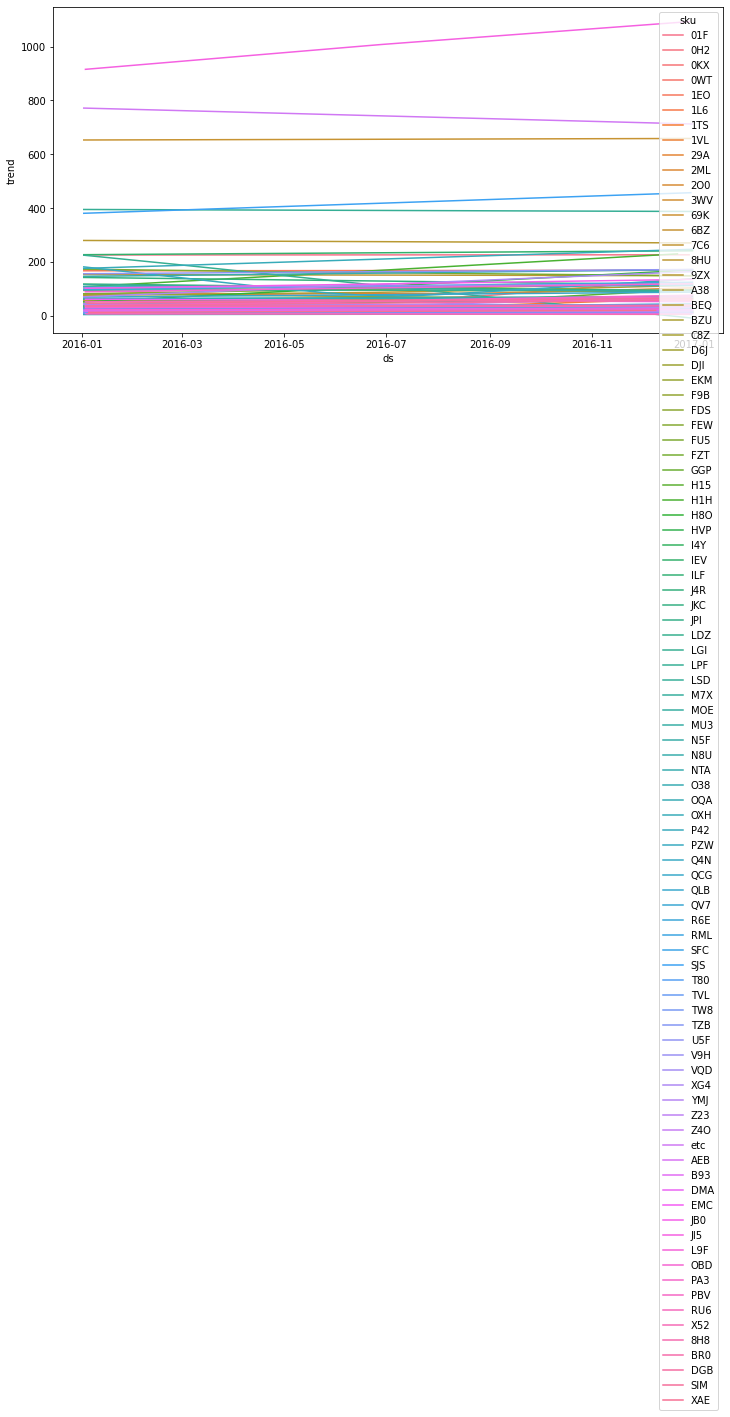

In [55]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = res, x = 'ds', y = 'trend', hue = 'sku')

# Iterators

In [56]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [57]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [58]:
a = (a*2 for a in range(100))
a

<generator object <genexpr> at 0x7f61db1f5350>

In [59]:
for _ in range(10) :
  print(next(a))

0
2
4
6
8
10
12
14
16
18


In [60]:
for _ in range(10) :
  print(next(a))

20
22
24
26
28
30
32
34
36
38
